<a href="https://colab.research.google.com/github/achal-durden/NLP-models/blob/master/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
          "dog cat animal", "cat animal dog", "cat dog animal"]

In [76]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [77]:
corpus=[i.split(" ") for i in corpus]

In [78]:
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [79]:
flat= lambda L: [item for i in L for item in i]

In [80]:
vocab=list(set(flat(corpus)))

In [81]:
vocab

['cat', 'fruit', 'dog', 'animal', 'apple', 'banana']

In [82]:
word2index = {v:k for k,v in enumerate(vocab)}

In [83]:
word2index['apple']

4

In [84]:
vocab.append('<UNK>')
word2index['<UNK>'] = 6

In [85]:
word2index.items()

dict_items([('cat', 0), ('fruit', 1), ('dog', 2), ('animal', 3), ('apple', 4), ('banana', 5), ('<UNK>', 6)])

In [86]:
index2word ={v:k for k, v in word2index.items()}

In [87]:
index2word[5]

'banana'

In [88]:
def random_batch(batch_size,corpus):

   skipgram=[]

   for doc in corpus:
      for i in range(1,len(doc)-1):
          center=word2index[doc[i]]
          outside=(word2index[doc[i-1]],word2index[doc[i+1]])
          for e in outside:
              skipgram.append([center,e])

   random_index=np.random.choice(range(len(skipgram)),batch_size,replace=False)
  #  print(random_index)
   input,labels=[],[]
   for index in random_index:
      input.append([skipgram[index][0]])
      labels.append([skipgram[index][1]])


   return np.array(input),np.array(labels)

In [89]:
x,y=random_batch(2,corpus)

In [90]:
emd=nn.Embedding(7,2)

In [91]:
x,y

(array([[5],
        [3]]),
 array([[4],
        [0]]))

In [92]:
class Skipgram(nn.Module):
    def __init__(self,voc_size,emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center=nn.Embedding(voc_size,emb_size)
        self.embedding_outside=nn.Embedding(voc_size,emb_size)


    def forward(self,center,outside,all_vocabs):
      center_embedding=self.embedding_center(center) #(batch_size, 1, emb_size)
      outside_embedding=self.embedding_outside(outside)
      all_vocabs_embedding=self.embedding_outside(all_vocabs)


      top_term=torch.exp(outside_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2))
      # top_term=torch.exp(outside_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2))

      lower_term=all_vocabs_embedding.bmm(center_embedding.transpose(1,2)).squeeze(2)

      lower_term_sum=torch.sum(torch.exp(lower_term),1)

      loss_fn=-torch.mean(torch.log((top_term/lower_term_sum)))

      return loss_fn



In [93]:
#prepare all vocabs

batch_size=2
voc_size = len(vocab)

def prepare_sequence(seq,word2index):

  idx=list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'],seq))
  return torch.LongTensor(idx)


all_vocab=prepare_sequence(list(vocab),word2index).expand(batch_size,voc_size)
all_vocab


tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [94]:
model=Skipgram(voc_size,2)
model

Skipgram(
  (embedding_center): Embedding(7, 2)
  (embedding_outside): Embedding(7, 2)
)

In [95]:
input_tensor = torch.LongTensor(x)
label_tensor = torch.LongTensor(y)

In [96]:
input_tensor.shape,label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [97]:
loss=model(input_tensor,label_tensor,all_vocab)
loss

tensor(1.5234, grad_fn=<NegBackward0>)

In [98]:
batch_size = 2
emb_size   = 2
model      = Skipgram(voc_size, emb_size)
optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [99]:
num_epochs=10000

for epoch in range(num_epochs):
  input_batch,label_batch=random_batch(batch_size,corpus)
  input_tensor=torch.LongTensor(input_batch)
  label_tensor=torch.LongTensor(label_batch)


  loss=model(input_tensor,label_tensor,all_vocab)

  optimizer.zero_grad()
  loss.backward()

  optimizer.step()

  if((epoch+1)%1000==0):
    print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")



Epoch   1000 | Loss: 1.589535
Epoch   2000 | Loss: 1.187958
Epoch   3000 | Loss: 1.105368
Epoch   4000 | Loss: 1.117853
Epoch   5000 | Loss: 1.082023
Epoch   6000 | Loss: 1.085363
Epoch   7000 | Loss: 1.130223
Epoch   8000 | Loss: 1.081376
Epoch   9000 | Loss: 1.131266
Epoch  10000 | Loss: 1.126192


In [100]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([5])

In [101]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)

banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed_c,banana_embed_o

(tensor([[-1.7048,  0.3342]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.5561, 0.1469]], grad_fn=<EmbeddingBackward0>))

In [102]:
def get_embed(word):
  try:
    index=word2index[word]
  except:
    index=word2index['<UNK>']

  word = torch.LongTensor([word2index[word]])
  embed_c = model.embedding_center(word)
  embed_o = model.embedding_outside(word)
  embed   = (embed_c + embed_o) / 2

  return embed[0][0].item(), embed[0][1].item()

In [103]:
get_embed('fruit')

(-0.8489255905151367, 0.361965537071228)

[]

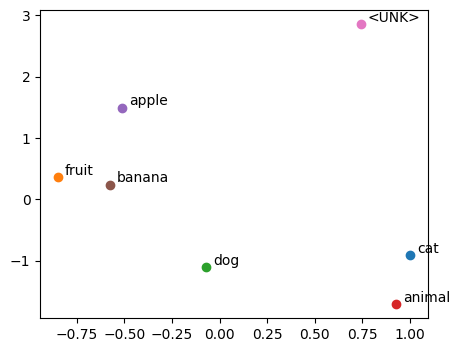

In [104]:
plt.figure(figsize=(5,4))
for i,word in enumerate(vocab):
   x,y=get_embed(word)
   plt.scatter(x,y)
   plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.plot()